In [1]:
import numpy as np
import cytnx as ct
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [2]:
def get_delta(beta,h):
    delta_t = ct.zeros((2,2,2,2))
    delta_t[0,0,0,0] = np.exp(beta*h)
    delta_t[1,1,1,1] = np.exp(-beta*h)
    delta_ut = ct.UniTensor(delta_t, rowrank=2)
    return delta_ut

In [3]:
def merge_y(T1,T2):
    net = ct.Network('./network/merge_y.net')
    net.PutUniTensors(['T1','T2'],[T1,T2])
    L2 = net.Launch()
    L2.combineBonds([1,2])
    L2.combineBonds([3,4])
    return L2

In [4]:
def get_T(J,beta,delta_ut):
    W=(np.exp(np.array([[J*beta, -J*beta],[-J*beta,J*beta]])))
    W_t = ct.from_numpy(W)
    S_t,U_t,Vd_t = ct.linalg.Svd(W_t)
    M_t = (U_t @ ct.linalg.Diag(S_t.Pow(0.5)))
    M_ut = ct.UniTensor(M_t,rowrank=1)
    net = ct.Network('./network/transfer.net')
    net.PutUniTensors(['delta','M1','M2','M3','M4'],
                  [delta_ut,M_ut,M_ut,M_ut,M_ut])
    return net.Launch()

In [5]:
def merge_x(T1,T2):
    net = ct.Network('./network/merge_x.net')
    net.PutUniTensors(['T1','T2'],[T1,T2])
    L2 = net.Launch()
    L2.combineBonds([0,1])
    L2.combineBonds([4,5])
    return L2

# Lx=1, L=1~10

In [6]:
J=1
h=0
Lmax=10
beta = 1/np.geomspace(2.26,2.38,50)

In [7]:
%%time
TM = {}
L = {}
u = {}
xi = {}
E = {}
for i in range(2,Lmax+1):
    xi[i] = []
for i in beta:
    delta_ut = get_delta(i,h)
    T_ut = get_T(J,i,delta_ut)
    for j in range(2,Lmax+1):
        #print(j)
        if j==2:
            L[j]=merge_y(T_ut,T_ut)
        else:
            L[j]=merge_y(L[j-1],T_ut)
        TM[j] = L[j].get_block().numpy()
        TM[j] = np.trace(TM[j],axis1=0,axis2=3)
        u[j],_ = np.linalg.eigh(TM[j])
        u[j] = u[j][::-1]
        E[j] = -np.log(u[j])
        xi[j].append(1/(E[j][1]-E[j][0]))

CPU times: user 1min 17s, sys: 18 s, total: 1min 35s
Wall time: 27.9 s


In [8]:
for i in range(2,Lmax+1):
    xi[i]=np.array(xi[i])
    xi[i]=xi[i]/i

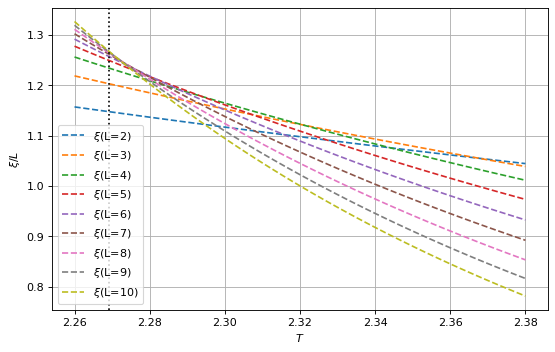

In [9]:
plt.figure(figsize=(8,5),dpi=80)
for i in range(2,Lmax+1):
    plt.plot(1/beta,xi[i],'--',label='$\\xi$(L=%d)' %i)
#for i in range(3,Lmax+1):
    #plt.plot(1/beta[np.argmin(np.abs(xi[i]-xi[i-1]))],xi[i][np.argmin(np.abs(xi[i]-xi[i-1]))],'r.')
plt.axvline(x=2/np.log(1+np.sqrt(2)),ls=':',c='k')
plt.legend()
plt.xlabel('$T$')
plt.ylabel('$\\xi/L$')
plt.grid()
plt.show()

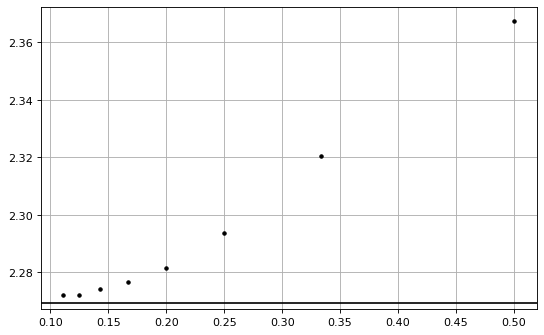

In [13]:
t_star = []

for i in range(3,Lmax+1):
    t_star.append(1/beta[np.argmin(np.abs(xi[i]-xi[i-1]))])
plt.figure(figsize=(8,5),dpi=80)
plt.plot(1/np.arange(2,Lmax),t_star,'.k')
plt.axhline(y=2/np.log(1+np.sqrt(2)),c='k')
plt.grid()
plt.show()

In [14]:
def obj(x,A,B,tc):
    return tc+A*(x**B)

In [21]:
popt, _ =curve_fit(obj, 1/np.arange(2,Lmax),t_star)


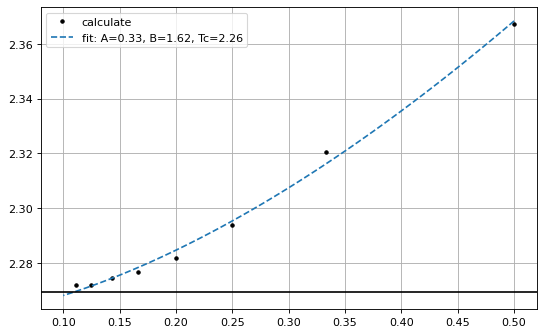

In [26]:
x = 1/np.geomspace(2,Lmax,100)
y = obj(x,popt[0],popt[1],popt[2])
plt.figure(figsize=(8,5),dpi=80)
plt.plot(1/np.arange(2,Lmax),t_star,'.k',label='calculate')
plt.plot(x,y,'--',label='fit: A={:.2f}, B={:.2f}, Tc={:.2f}'.format(popt[0],popt[1],popt[2]))
plt.axhline(y=2/np.log(1+np.sqrt(2)),c='k')
plt.grid()
plt.legend()
plt.show()

In [ ]:
del TM, L, u, xi, E

# Lx=2, Ly=1~9

In [ ]:
J=1
h=0
Lmax=9
beta = 1/np.geomspace(2.26,2.38,50)

In [ ]:
%%time
TM2 = {}
L2 = {}
u2 = {}
xi2 = {}
E2 = {}
for i in range(2,Lmax+1):
    xi2[i] = []
for i in beta:
    delta_ut = get_delta(i,h)
    T_ut = get_T(J,i,delta_ut)
    T_x2 = merge_x(T_ut,T_ut)
    for j in range(2,Lmax+1):
        if j==2:
            L2[j]=merge_y(T_x2,T_x2)
        else:
            L2[j]=merge_y(L2[j-1],T_x2)
        TM2[j] = L2[j].get_block().numpy()
        TM2[j] = np.trace(TM2[j],axis1=0,axis2=3)
        u2[j],_ = np.linalg.eigh(TM2[j])
        u2[j] = u2[j][::-1]
        E2[j] = -np.log(u2[j])
        xi2[j].append(1/(E2[j][1]-E2[j][0]))

In [ ]:
for i in range(2,Lmax+1):
    xi2[i]=np.array(xi2[i])
    xi2[i]=xi2[i]/i

In [ ]:
plt.figure(figsize=(8,5),dpi=80)
for i in range(2,Lmax+1):
    plt.plot(1/beta,xi2[i],'.--',label='$\\xi$(L=%d)' %i)
#for i in range(3,Lmax+1):
    #plt.plot(1/beta[np.argmin(np.abs(xi[i]-xi[i-1]))],xi[i][np.argmin(np.abs(xi[i]-xi[i-1]))],'r.')
plt.axvline(x=2/np.log(1+np.sqrt(2)),ls=':',c='k')
plt.legend()
plt.xlabel('$T$')
plt.ylabel('$\\xi/L$')
plt.grid()
plt.show()

In [ ]:
del TM2, L2, u2, xi2, E2

## Compare with L=1

In [ ]:
Ly=2

In [ ]:
%%time
TM = {}
L = {}
u = {}
E = []
for i in beta:
    delta_ut = get_delta(i,h)
    T_ut = get_T(J,i,delta_ut)
    for j in range(2,Ly+1):
        #print(j)
        if j==2:
            L[j]=merge_y(T_ut,T_ut)
        else:
            L[j]=merge_y(L[j-1],T_ut)
        if j==Ly:    
            TM[j] = L[j].get_block().numpy()
            TM[j] = np.trace(TM[j],axis1=0,axis2=3)
            u[j],_ = np.linalg.eigh(TM[j])
            u[j] = u[j][::-1]
            E.append(-np.log(u[j][0]))

In [ ]:
%%time
TM2 = {}
L2 = {}
u2 = {}
E2 = []
for i in beta:
    delta_ut = get_delta(i,h)
    T_ut = get_T(J,i,delta_ut)
    T_x2 = merge_x(T_ut,T_ut)
    for j in range(2,Ly+1):
        if j==2:
            L2[j]=merge_y(T_x2,T_x2)
        else:
            L2[j]=merge_y(L2[j-1],T_x2)
        if j==Ly:
            TM2[j] = L2[j].get_block().numpy()
            TM2[j] = np.trace(TM2[j],axis1=0,axis2=3)
            u2[j],_ = np.linalg.eigh(TM2[j])
            u2[j] = u2[j][::-1]
            E2.append(-np.log(u2[j][0])) 

In [ ]:
E = np.array(E)
E2 = np.array(E2)

In [ ]:
plt.plot(1/beta, E,label='Lx=1')
plt.plot(1/beta, E2,label='Lx=2')
plt.legend()
plt.xlabel('$T$')
plt.ylabel('$\\xi/L$')
plt.show()

In [ ]:
plt.plot(1/beta, E*2,label='Lx=1')
plt.plot(1/beta, E2,'--',label='Lx=2')
plt.legend()
plt.xlabel('$T$')
plt.ylabel('$\\xi/L$')
plt.title('E(Lx=1)*2 and E(Lx=2)')
plt.show()

# Square Contraction

In [15]:
J=1
h=0
Lmax=4
beta = 1/np.geomspace(2.26,2.38,10)

In [ ]:
L = {}
xi = {}
for i in range(2,Lmax+1):
    xi[i] = []
for i in beta:
    delta_ut = get_delta(i,h)
    T_ut = get_T(J,i,delta_ut)
    
    for j in range(2,Lmax+1):
        if j==2:
            L[j] = merge_x(T_ut,T_ut)
            L[j] = merge_y(L[j],L[j])
        else:
            L[j] = merge_y(L[j-1],L[j-1])
            L[j] = merge_x(L[j],L[j])
        TM = L[j].get_block().numpy()
        TM = np.trace(TM,axis1=0,axis2=3)
        u,_ = np.linalg.eigh(TM)
        u = u[::-1]
        E = -np.log(u)
        xi[j].append(1/(E[1]-E[0]))
del L

In [13]:
for i in range(2,Lmax+1):
    xi[i]=np.array(xi[i])
    #xi[i]=xi[i]/(2**(i-1))

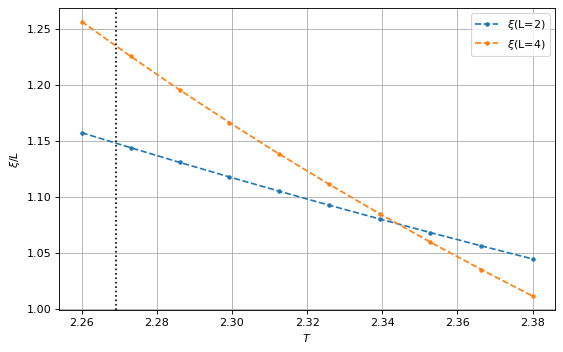

In [14]:
plt.figure(figsize=(8,5),dpi=80)
for i in range(2,Lmax+1):
    plt.plot(1/beta,xi[i],'.--',label='$\\xi$(L=%d)' %(2**(i-1)))
#for i in range(3,Lmax+1):
    #plt.plot(1/beta[np.argmin(np.abs(xi[i]-xi[i-1]))],xi[i][np.argmin(np.abs(xi[i]-xi[i-1]))],'r.')
plt.axvline(x=2/np.log(1+np.sqrt(2)),ls=':',c='k')
plt.legend()
plt.xlabel('$T$')
plt.ylabel('$\\xi/L$')
plt.grid()
plt.show()

# Compare with Ly=[2,4], Lx=1

In [6]:
J=1
h=0
Lmax_s=2
Lmax = 4
beta = 1/np.geomspace(2.26,2.38,10)

In [7]:
L = {}
xi_s = {}
for i in range(2,Lmax_s+1):
    xi_s[i] = []
for i in beta:
    delta_ut = get_delta(i,h)
    T_ut = get_T(J,i,delta_ut)
    
    for j in range(2,Lmax_s+1):
        
        if j==2:
            L[j] = merge_x(T_ut,T_ut)
            L[j] = merge_y(L[j],L[j])
        else:
            L[j] = merge_y(L[j-1],L[j-1])
            L[j] = merge_x(L[j],L[j])
        TM = L[j].get_block().numpy()
        TM = np.trace(TM,axis1=0,axis2=3)
        u,_ = np.linalg.eigh(TM)
        u = u[::-1]
        E = -np.log(u)
        xi_s[j].append(1/(E[1]-E[0]))
del L

In [ ]:
for i in range(2,Lmax_s+1):
    xi_s[i]=np.array(xi_s[i])
    print(2**(i-1))
    xi_s[i]=xi_s[i]/(2**(i-1))

In [ ]:
plt.figure(figsize=(8,5),dpi=80)
for i in range(2,Lmax_s+1):
    plt.plot(1/beta,xi_s[i],'.--',label='$\\xi$(L=%d)' %(2**(i-1)))
plt.axvline(x=2/np.log(1+np.sqrt(2)),ls=':',c='k')
plt.legend()
plt.xlabel('$T$')
plt.ylabel('$\\xi/L$')
plt.xlim([2.26,2.38])
plt.title('Square merge')
plt.grid()
plt.show()

In [ ]:
%%time
TM = {}
L = {}
u = {}
xi = {}
E = {}
for i in range(2,Lmax+1):
    xi[i] = []
for i in beta:
    delta_ut = get_delta(i,h)
    T_ut = get_T(J,i,delta_ut)
    for j in range(2,Lmax+1):
        #print(j)
        if j==2:
            L[j]=merge_y(T_ut,T_ut)
        else:
            L[j]=merge_y(L[j-1],T_ut)
        TM[j] = L[j].get_block().numpy()
        TM[j] = np.trace(TM[j],axis1=0,axis2=3)
        u[j],_ = np.linalg.eigh(TM[j])
        u[j] = u[j][::-1]
        E[j] = -np.log(u[j])
        xi[j].append(1/(E[j][1]-E[j][0]))
del TM, L, u, E

In [ ]:
for i in range(2,Lmax+1):
    xi[i]=np.array(xi[i])
    xi[i]=xi[i]/i

In [ ]:
plt.figure(figsize=(8,5),dpi=80)
for i in range(2,Lmax_s+1):
    plt.plot(1/beta,xi_s[i],'--',label='$\\xi$(L=%d), square merge' %i)
for i in [2,4]:
    plt.plot(1/beta,xi[i],'.',label='$\\xi$(L=%d), Lx=1' %i)
plt.axvline(x=2/np.log(1+np.sqrt(2)),ls=':',c='k')
plt.legend()
plt.xlabel('$T$')
plt.ylabel('$\\xi/L$')
plt.grid()
plt.show()